In [1]:
# import confusionTable_extractFeature as CTF

In [2]:
import math

In [3]:
import sys
import os
import argparse

In [4]:
from multiprocessing import Pool

In [5]:
import pickle
import numpy as np
from sklearn import svm

In [6]:
from sklearn.preprocessing import Normalizer, StandardScaler

In [7]:
from sklearn.naive_bayes import GaussianNB

In [8]:
from collections import defaultdict
import matplotlib.pyplot as plt

In [9]:
with open('./ch_5401.txt', 'r', encoding='utf8') as fp:                    
    CH5400 = set(i.strip() for i in fp.readlines())

In [10]:
POS = 1
NEG = -1
UNK = 2

In [11]:
PROCESSCNT = 6
MULTIPROCESS = True
PRE = False
NB = False

In [12]:
def fCombine(score, log):
    '''The method of extract feature 
    Args:
        score(float): total score of feature 
        log(list): feature 
    Return:
        tmp(list): selected feature 
    '''
    # 0.89/0.86    
#     tmp = log[:-2]
#     tmp.append(score-log[-3]*9-log[-2])
    
    
    # 0.90/0.89
#     tmp = log[:-2]

    # 0.90/0.89
#     tmp = log[:-2]

    # 0.99/0.99
#     tmp = log[:-2]
#     tmp.append(score)

    # 0.89/0.86
#     tmp = log[:-2]
#     s = sum(log[:-2])
#     tmp.append(s)

    # 0.99/0.99
    tmp = log[:-2]
    s = score - log[-3]*9
    tmp.append(s)
    
    
    return tmp

In [13]:
def extract(dataset):
    '''Extract (feature/label) from filename
    Args:
        bigDict (nested dict): the dict of feature (*.pkl) from confusionTable_extractFeature
    Return:
        train_feature (np.array): feature array
        train_label (np.array): the label of feature             
    '''    
    
    # Initial 
    label = list()
    feature = list()

    for error_ch, (cands_val) in dataset.items():           
        if error_ch not in CH5400:
            # If confusion matrix have, choose 
            # else choose the highest score            
            in_pairs = {cand:(score, log) for cand, (score, log) in cands_val.items() if log[-2]!=0}
            if not in_pairs:
                try:
                    best_cand = max(cands_val.items(), key=lambda x:x[1][0])                
                except:
                    print(cands_val)
                    return 
                dataset[error_ch] = {best_cand[0]:best_cand[1]}
            else:
                dataset[error_ch] = in_pairs
            continue        
        
        # two situation for error: (error-pair) or (higher-score)
        # Skip the candidates which is not in COMMON-5000
        for cand, (score, log) in cands_val.items():  
            if cand not in CH5400:
                continue
                                    
            feature.append(fCombine(score,log))
            if log[-2] != 0:
                label.append(POS)
            else:
                label.append(UNK)
    
    # Combine
    train_feature = np.asarray(feature, dtype='float')            
    tmp_label = np.asarray(label, dtype='int')
    pos = np.where(tmp_label == POS )[0]
    neg = np.where(tmp_label == UNK )[0]
    train_label = {POS:pos, UNK:neg}        

    print('The number of sample = {}'.format(train_feature.shape))
    print('Positive case (candidate) = {}'.format(len(train_label[POS])))
    print('Negative case (uncandidate) = {}'.format(len(train_label[UNK])))
    
    return (train_feature, train_label)

In [14]:
def preprocess(data, method):
    '''Preprocessing of feature    
    Args:
        data (np.array): feature 
        method (str): 'normal'-normalization // 'standard'-standardization
        (Normal is better)
    Return:
        new_data (np.array): after preprocessing 
        pre (scikit.preprocess): transform model for feature     
    '''
    if PRE:    
        if method == 'normal':
            pre = Normalizer().fit(data)
            new_data = pre.transform(data)
        elif method == 'standard':
            pre = Normalizer().fit(data)
            new_data = pre.transform(data)
        else:
            print('Unknown method')
            sys.exit(0)
        
        return (new_data, pre)
    else:
        return (data, [])

In [15]:
def rnBatch(para):
    (idx, feature, nbf) = para
    
    if nbf.predict(feature.reshape(1,-1)) == UNK:
        return idx
    else:
        return -1

In [16]:
def rnSelect(feature, label):
    
    if NB:
        
        nbf_idx = np.concatenate((label[POS],label[UNK]))
        nbf_label = np.concatenate(
            (np.full(len(label[POS]), POS, dtype=int)
             , np.full(len(label[UNK]), UNK, dtype=int)))
        nbf_feature = feature[nbf_idx]
        nbf = GaussianNB().fit(nbf_feature, nbf_label)

        print('Prepare chunk')
        chunk = [(idx, feature[idx], nbf) for idx in label[UNK]]

        print('Start RN step select')    
        if MULTIPROCESS:
            with Pool(processes=PROCESSCNT) as pool:
                rn_neg = pool.map(rnBatch, chunk)
        else:
            rn_neg = [rnBatch(c) for c in chunk]


        label[NEG] = np.where(np.asarray(rn_neg) != -1)[0]


        print('Label[POS]: {}'.format(len(label[POS])))
        print('Label[NEG]: {}'.format(len(label[NEG])))
        print('Remove Unknown {} samples'.format(len(label[UNK])-len(label[NEG])))
    
    else:
        label[NEG] = label[UNK]
    
    return label

In [104]:
def train_svm(feature, label, train_cnt, cost= 0, g=1/11, test_cnt=0, cross_validation=False):
    '''Train SVM model from feature
    Args:
        feature (np.array): feature array
        label (np.array): the label of feature 
        train_cnt (int): the number of training samples 
        test_cnt (int): (default=samples-train_cnt) the number of testing samples
    Return:
        xxx    
    '''
    
    assert train_cnt < len(label[POS]), 'Train count must less than positive samples'
    
    # If test_cnt not declare, use all the remain set as test set    
    if train_cnt==0:
        assert False, 'sample count cannot be zero'
        
    if test_cnt==0:
        test_cnt = len(label[POS]) - train_cnt
        
    # Picke feature/label to train & test set    
    np.random.shuffle(label[POS])
    np.random.shuffle(label[NEG])

    train_idx = np.concatenate(
        (label[POS][:train_cnt],
         label[NEG][:train_cnt]))
    train_label = np.concatenate(
        (np.full(train_cnt, POS, dtype=int), np.full(train_cnt, NEG, dtype=int)))
    train_feature = feature[train_idx]

    test_idx = np.concatenate(
        (label[POS][train_cnt:train_cnt+test_cnt], 
         label[NEG][train_cnt:train_cnt+test_cnt]))
    test_label = np.concatenate(
        (np.full(test_cnt, POS, dtype=int), np.full(test_cnt, NEG, dtype=int)))
    test_feature = feature[test_idx]

    # Training 
    clf = svm.SVC(kernel='rbf',C=cost,gamma=g, probability=True)
    clf.fit(train_feature,train_label)
    
    # Testing 
    accuracy = clf.score(test_feature, test_label)
    pos_acc = clf.score(test_feature[:test_cnt], test_label[:test_cnt])
    print('Accuracy ({}/{}): {}'.format(test_cnt, len(test_label), accuracy))
    print('Positive Accuracy ({}): {}'.format(test_cnt, pos_acc))
    
    
    test_idx = np.concatenate(
        (label[POS][train_cnt:], 
         label[NEG][train_cnt:]))
    test_label = np.concatenate(
        (np.full(len(label[POS][train_cnt:]), POS, dtype=int),
         np.full(len(label[NEG][train_cnt:]), NEG, dtype=int)))
    test_feature = feature[test_idx]
    
    
    vali_pred = clf.predict(train_feature)
    test_pred = clf.predict(test_feature)
    vali_matrix = [vali_pred, train_label]
    test_matrix = [test_pred, test_label]
    
    
    
#     output = [accuracy, train_cnt, test_cnt*2]
#     return output
    return clf, vali_matrix, test_matrix

In [18]:
def create_batch(chunk):
    global clf
    global pre_filter
    global threshold
    
    (ch, cands) = chunk  
    
    f_batch = []
    for ca, (score,log) in cands.items(): 
        if ca not in CH5400:
            continue        
        
        if False:
#         if log[-2] != 0:
            f_batch.append((ca, 1))   
        else:
            cand_feature = fCombine(score,log)
            if PRE:                
                tmp = pre_filter.transform(np.asarray(cand_feature).reshape(1,-1))
            else:
                tmp = np.asarray(cand_feature).reshape(1,-1)
            
            f = clf.predict_proba(tmp).tolist()[0]            
                               
            if f[1] > f[0] and f[1] > threshold[0]:
                f_batch.append((ca, f[1]))
#             elif log[-2] != 0:
#                 print(ch, ca)

    if len(f_batch) > 0:
        f_sorted = sorted(f_batch, key=lambda x:x[1], reverse=True)[:threshold[1]]
        f_dict = {ca:s for ca, s in f_sorted}

        return (ch, f_dict)
    else:
        return []


In [18]:
def create_batch(chunk):
    global clf
    global pre_filter
    global threshold
    
    (ch, cands) = chunk  
    
    f_batch = []
    for ca, (score,log) in cands.items(): 
        if ca not in CH5400:
            continue        
        
        if False:
#         if log[-2] != 0:
            f_batch.append((ca, 1))   
        else:
            cand_feature = fCombine(score,log)
            if PRE:                
                tmp = pre_filter.transform(np.asarray(cand_feature).reshape(1,-1))
            else:
                tmp = np.asarray(cand_feature).reshape(1,-1)
            
            f = clf.predict_proba(tmp).tolist()[0]            
                               
            if f[1] > f[0] and f[1] > threshold[0]:
                f_batch.append((ca, f[1]))
#             elif log[-2] != 0:
#                 print(ch, ca)

    if len(f_batch) > 0:
        f_sorted = sorted(f_batch, key=lambda x:x[1], reverse=True)[:threshold[1]]
        f_dict = {ca:s for ca, s in f_sorted}

        return (ch, f_dict)
    else:
        return []


In [19]:
def create(bigDict):    
    '''Select the candidates in bigDict
    
    '''    
    confusion = dict()
    c_t, c_tf, sk = 0,0,0
    
    tt = list(bigDict.items())
    
    if MULTIPROCESS:
        with Pool(processes=PROCESSCNT) as pool:
            r = pool.map(create_batch, tt)
        confusion = {c[0]:c[1] for c in r if len(c)>0}
    else:
        for chunk in tt:
            batch = create_batch(chunk)
            if len(batch)>0:
                confusion[batch[0]] = batch[1] 
            
    return confusion

In [20]:
def info(confusion, fig_token):
    '''Get basic information about NCM 
    
    '''
    total_error = len(confusion)
    cands = [(ch, len(cand)) for (ch, cand) in 
        sorted(confusion.items(), key= lambda x:len(x[1]), reverse=True)]

    sum_cands = sum(cnt for _, cnt in cands)
    max_cands = max(cnt for _, cnt in cands)
    min_cands = min(cnt for _, cnt in cands)
    mean_cands = sum_cands/total_error
    
    if total_error%2 == 0:
        mid_cands = cands[total_error//2]
    else:
        mid_cands = cands[(total_error+1)//2]
    
    print('Total_error: {}\nSum_cands: {}'.format(total_error, sum_cands))
    print('Max_cands: {}\nMin_cands: {}'.format(max_cands, min_cands))
    print('Mean_cands: {:.2f}\nMid_cands: {}'.format(mean_cands, mid_cands))
    print('Top 20 cands:\n {}'.format(cands[:20]))
    
    plt.plot([cnt for _, cnt in cands])
    plt.xlabel('Index')
    plt.ylabel('Number of candidates')
    fig = plt.gcf()
    plt.show()
    fig.savefig('./confusionTable/confuInfo_{}.png'.format(fig_token), dpi=100)

In [22]:
data_root = './confusionTable/basicExtact/'
filelist = {file:os.path.join(data_root, file) for _,_,files in os.walk(data_root) for file in files if 'confu' in os.path.splitext(file)[0]}

In [23]:
filelist

{'confu_all.pkl': './confusionTable/basicExtact/confu_all.pkl',
 'confu_in_1.pkl': './confusionTable/basicExtact/confu_in_1.pkl',
 'confu_in_2.pkl': './confusionTable/basicExtact/confu_in_2.pkl',
 'confu_in_3.pkl': './confusionTable/basicExtact/confu_in_3.pkl',
 'confu_in_4.pkl': './confusionTable/basicExtact/confu_in_4.pkl',
 'confu_in_5.pkl': './confusionTable/basicExtact/confu_in_5.pkl',
 'confu_in_6.pkl': './confusionTable/basicExtact/confu_in_6.pkl'}

Total_error: 18063
Sum_cands: 3428471
Max_cands: 1407
Min_cands: 1
Mean_cands: 189.81
Mid_cands: ('鍜', 147)
Top 20 cands:
 [('扢', 1407), ('鳽', 1306), ('厭', 1244), ('膁', 1203), ('誒', 1158), ('咭', 1135), ('歘', 1112), ('苑', 1080), ('苴', 1057), ('閼', 1039), ('齊', 1002), ('羛', 975), ('嵠', 971), ('扦', 966), ('鉈', 959), ('幵', 958), ('踦', 958), ('錡', 957), ('葴', 957), ('邪', 948)]


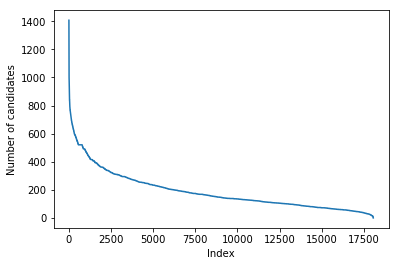

Total_error: 18063
Sum_cands: 64357
Max_cands: 38
Min_cands: 1
Mean_cands: 3.56
Mid_cands: ('蔱', 1)
Top 20 cands:
 [('淅', 38), ('淹', 38), ('淤', 38), ('淵', 38), ('淆', 38), ('淑', 38), ('淋', 38), ('涪', 38), ('清', 38), ('液', 38), ('深', 38), ('淨', 38), ('涎', 38), ('淫', 38), ('淘', 38), ('淪', 38), ('淙', 38), ('涯', 38), ('淞', 38), ('涮', 38)]


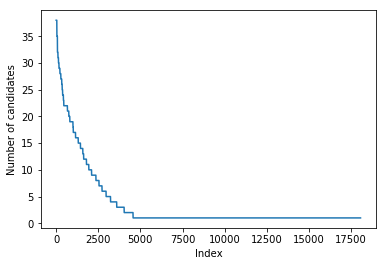

Total_error: 18063
Sum_cands: 319045
Max_cands: 298
Min_cands: 1
Mean_cands: 17.66
Mid_cands: ('芑', 1)
Top 20 cands:
 [('居', 298), ('行', 288), ('癘', 287), ('藉', 284), ('吃', 252), ('戲', 250), ('枝', 239), ('祇', 239), ('釐', 236), ('圾', 229), ('契', 226), ('攜', 224), ('祭', 223), ('漆', 209), ('奇', 207), ('驥', 207), ('稽', 207), ('畦', 207), ('畸', 207), ('屐', 207)]


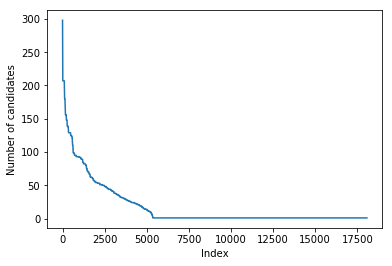

Total_error: 18063
Sum_cands: 3946218
Max_cands: 1422
Min_cands: 1
Mean_cands: 218.47
Mid_cands: ('庉', 177)
Top 20 cands:
 [('扢', 1422), ('鳽', 1317), ('厭', 1257), ('膁', 1221), ('誒', 1163), ('咭', 1147), ('苑', 1130), ('歘', 1116), ('苴', 1077), ('齊', 1067), ('閼', 1044), ('姬', 1033), ('錡', 1026), ('訢', 1012), ('邪', 1010), ('羛', 1003), ('幵', 1003), ('嵠', 975), ('扦', 975), ('踦', 968)]


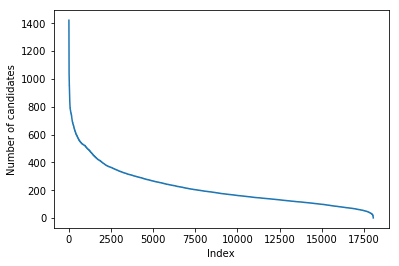

Total_error: 18063
Sum_cands: 27147
Max_cands: 17
Min_cands: 1
Mean_cands: 1.50
Mid_cands: ('唹', 1)
Top 20 cands:
 [('愉', 17), ('息', 15), ('識', 15), ('是', 14), ('愚', 14), ('如', 14), ('付', 13), ('事', 13), ('胡', 13), ('新', 12), ('而', 12), ('俞', 12), ('折', 12), ('緣', 11), ('資', 11), ('余', 11), ('兒', 11), ('決', 11), ('知', 11), ('適', 11)]


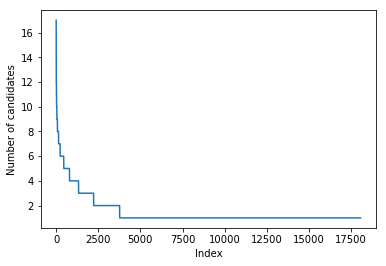

Total_error: 18063
Sum_cands: 392799
Max_cands: 138
Min_cands: 1
Mean_cands: 21.75
Mid_cands: ('捾', 20)
Top 20 cands:
 [('雒', 138), ('瞿', 127), ('奪', 118), ('雅', 117), ('雚', 116), ('焦', 113), ('雃', 109), ('翟', 106), ('雍', 105), ('釁', 105), ('崔', 105), ('雐', 104), ('難', 102), ('雉', 102), ('霍', 99), ('隿', 99), ('雤', 99), ('斪', 99), ('舋', 98), ('雋', 96)]


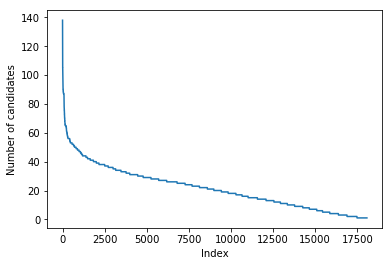

Total_error: 18063
Sum_cands: 153286
Max_cands: 31
Min_cands: 1
Mean_cands: 8.49
Mid_cands: ('墙', 1)
Top 20 cands:
 [('炫', 31), ('彫', 31), ('糙', 31), ('兵', 31), ('崴', 31), ('碰', 31), ('緻', 31), ('伺', 31), ('熬', 31), ('墾', 31), ('駒', 31), ('率', 31), ('娣', 31), ('珪', 31), ('諮', 31), ('晨', 31), ('曄', 31), ('穆', 31), ('妣', 31), ('邸', 31)]


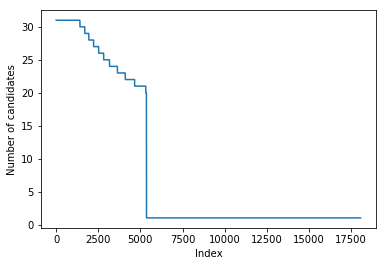

In [24]:
for filename, path in filelist.items():
    sys_c = sysExtract(path)
    info(sys_c, os.path.splitext(filename)[0])

In [21]:
def sysExtract(confusionset_file):
    ncm = pickle.load(open(confusionset_file, 'rb'))
    sys_confusion = defaultdict(set)
    for error, cands_info in ncm.items():
        sys_confusion[error].update(cands_info.keys())
        
    return sys_confusion

In [22]:
def outputPKL(confusion, ncm_correct, pkl_file):
    '''Assign local probability and output to NCM file
    '''
    output = defaultdict(dict)
    print('Output PKL')
    for ch, cands in confusion.items():
        total_cand_val = sum(cands.values())*(1-ncm_correct) + ncm_correct
        output[ch] = {ca:(p*(1-ncm_correct))/total_cand_val for ca,p in cands.items()}
        output[ch][ch] = ncm_correct/total_cand_val        
    
    with open(pkl_file, 'wb') as fp:
        pickle.dump(output, fp)
    
    return output

In [23]:
def process_command():
    parser = argparse.ArgumentParser()
    parser.add_argument('--token', required=True)
    parser.add_argument('--multi', action='store_false')
    parser.add_argument('--pre', action='store_true')
    parser.add_argument('--nb', action='store_true')    
    
    return parser.parse_args()

In [24]:
# args = process_command()
feature_file = './confusionTable/feature_0522.pkl'
output_file = './confusionTable/confu_{}_{}_{}.pkl'.format

with open(feature_file, 'rb') as fp:
    dataset = pickle.load(fp)        

In [25]:
print('Before extract = {}'.format(sum(len(cand) for cand in dataset.values())))

Before extract = 2592820


In [26]:
feature,label = extract(dataset)
print('After extract = {}'.format(sum(len(cand) for cand in dataset.values())))

The number of sample = (1561823, 11)
Positive case (candidate) = 8400
Negative case (uncandidate) = 1553423
After extract = 1717879


In [144]:
PRE = False
NB = False
train_cnt = 2000
cost = 5
gamma= 0.0225

In [145]:
(new_feature, pre_filter) = preprocess(feature, 'normal')
label = rnSelect(new_feature, label)            
clf, vali_p, test_p = train_svm(new_feature, label, train_cnt, cost, gamma)

Accuracy (6400/12800): 0.998125
Positive Accuracy (6400): 0.9984375


In [146]:
cnf_mv = confusion_matrix(y_pred=vali_p[0], y_true=vali_p[1])

In [147]:
cnf_mv = np.rot90(cnf_mv, 2)

In [148]:
cnf_mv

array([[1996,    4],
       [   4, 1996]])

In [154]:
plt.savefig?

In [165]:
plt.figure()
plot_confusion_matrix(cnf_mv, classes=['True','False'],normalize=True,
                      title='Confusion matrix, without normalization')
plt.savefig('./confusionTable/validate.png', dpi=100)
# plt.show()

Normalized confusion matrix
[[ 0.998  0.002]
 [ 0.002  0.998]]


In [150]:
cnf_mt = confusion_matrix(y_pred=test_p[0], y_true=test_p[1])

In [151]:
cnf_mt = np.rot90(cnf_mt,2)

In [152]:
cnf_mt

array([[   6390,      10],
       [   3379, 1548044]])

In [164]:
plt.figure()
plot_confusion_matrix(cnf_mt, classes=['True','False'],normalize=True,
                      title='Confusion matrix, without normalization')
plt.savefig('./confusionTable/test.png', dpi=100)
# plt.show()

Normalized confusion matrix
[[ 0.9984375  0.0015625]
 [ 0.002178   0.997822 ]]


In [39]:
dataset['信']

{'一': (5.9703974241725799,
  [0, 0, 0, 0, 0, 0, 4.0, -3.186522, -2.495364, 0.19703974241725797, 0, []]),
 '三': (5.2670356474223148,
  [0, 0, 0, 0, 0, 0, 3.0, -3.186522, -2.823071, 0.22670356474223149, 0, []]),
 '上': (6.7042288504853378,
  [0, 0, 0, 1, 0, 0, 4.0, -3.186522, -2.654677, 0.17042288504853373, 0, []]),
 '下': (5.8598887552963159,
  [0, 0, 0, 0, 0, 0, 4.0, -3.186522, -2.724198, 0.18598887552963156, 0, []]),
 '不': (6.4847053663727205,
  [0, 0, 0, 0, 0, 0, 4.0, -3.186522, -2.531445, 0.248470536637272, 0, []]),
 '且': (5.2013876294807115,
  [0, 0, 0, 0, 0, 0, 3.0, -3.186522, -3.336532, 0.22013876294807116, 0, []]),
 '並': (5.3410766146490154,
  [0, 0, 0, 0, 0, 0, 3.0, -3.186522, -2.879576, 0.23410766146490158, 0, []]),
 '中': (8.2565433168432172,
  [0, 0, 0, 0, 0, 0, 4.0, -3.186522, -2.608095, 0.42565433168432165, 0, []]),
 '主': (5.2309479199544029,
  [0, 0, 0, 0, 0, 0, 3.0, -3.186522, -2.857516, 0.2230947919954403, 0, []]),
 '久': (5.0797825728092949,
  [0, 0, 0, 0, 0, 0, 3.0, -3.18

In [41]:
score, log = dataset['信']['今']

In [42]:
fff = fCombine(score, log)

In [46]:
log[-2] == 0

[0, 0, 0, 1, 0, 0, 3.0, -3.186522, -3.175858, 0.19084640315413054, 0, []]

In [45]:
len(log[-1])

0

In [43]:
fff

[0,
 0,
 0,
 1,
 0,
 0,
 3.0,
 -3.186522,
 -3.175858,
 0.19084640315413054,
 4.1908464031541302]

In [95]:
label[-1]

array([1469571,  332118,  203670, ...,  595908,  251154,  615528])

In [94]:
clf.predict(feature[:10])

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [47]:
tp_case = 0
fp_case = 0
fn_case = 0 
tn_case = 0

for ch_a, cands in dataset.items():
    for cand, (score, log) in cands.items():
        cand_feature = fCombine(score, log)
        if PRE:                
            tmp = pre_filter.transform(np.asarray(cand_feature).reshape(1,-1))
        else:
            tmp = np.asarray(cand_feature).reshape(1,-1)
            
        f = clf.predict_proba(tmp).tolist()[0]
        
        
        if f[1]>=f[0]:
            # True positive
            if log[-2] != 0:
                tp_case += 1
            # False positive 
            else:
                fp_case += 1            
        else:
            # Fasle negative 
            if log[-2] != 0:
                fn_case += 1
            else:
                tn_case += 1

In [48]:
tp_case

8960

In [49]:
fp_case

30908

In [50]:
fn_case

397

In [51]:
tn_case

1677614

In [80]:
X = np.concatenate((np.full(tp_case+fn_case,0,dtype='int'), np.full(fp_case+tn_case,1,dtype='int')))

In [81]:
Y = np.concatenate((np.full(tp_case,0,dtype='int'), np.full(fn_case,1,dtype='int'),
                   np.full(fp_case,0,dtype='int'), np.full(tn_case,1,dtype='int')))

In [64]:
from sklearn.metrics import confusion_matrix
import itertools


In [76]:
len(np.where(X==1)[0])

9357

In [82]:
cnf_matrix = confusion_matrix(X,Y)

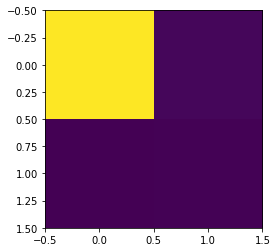

In [69]:
plt.imshow(cnf_matrix)
plt.show()

In [163]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.4f}'.format(cm[i, j]),
                 horizontalalignment="center", 
                 color="red")
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [162]:
plt.text?

In [72]:
cnf_matrix

array([[1677614,   30908],
       [    397,    8960]])

Normalized confusion matrix
[[ 0.95757187  0.04242813]
 [ 0.01809049  0.98190951]]


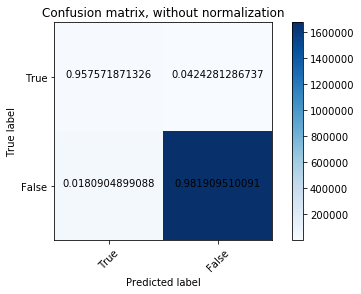

In [92]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['True','False'],normalize=True,
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
 cand_feature = fCombine(score,log)
            if PRE:                
                tmp = pre_filter.transform(np.asarray(cand_feature).reshape(1,-1))
            else:
                tmp = np.asarray(cand_feature).reshape(1,-1)
            
            f = clf.predict_proba(tmp).tolist()[0]            
                               
            if f[1] > f[0] and f[1] > threshold[0]:
                f_batch.append((ca, f[1]))

In [37]:
label

{-1: array([1469571,  332118,  203670, ...,  595908,  251154,  615528]),
 1: array([ 597608,  416448,  625737, ...,  802907, 1533169,  365453]),
 2: array([1469571,  332118,  203670, ...,  595908,  251154,  615528])}

In [34]:
clf.score(new_feature, label)

ValueError: Found input variables with inconsistent numbers of samples: [3, 1561823]

In [33]:
accuracy

0.98858108108108111

PRE	False
NB	False
trainSet = 4000	cost_pars = 1	gamma = 0.09
Accuracy (4400/8800): 0.9931818181818182
Positive Accuracy (4400): 0.9986363636363637
Total_error: 5152
Sum_cands: 19638
Max_cands: 26
Min_cands: 1
Mean_cands: 3.81
Mid_cands: ('靦', 3)
Top 20 cands:
 [('是', 26), ('事', 22), ('經', 19), ('以', 18), ('理', 18), ('付', 18), ('古', 18), ('至', 18), ('維', 17), ('模', 17), ('奇', 17), ('期', 17), ('時', 17), ('住', 17), ('莫', 16), ('裡', 16), ('愈', 16), ('適', 16), ('愉', 16), ('其', 16)]


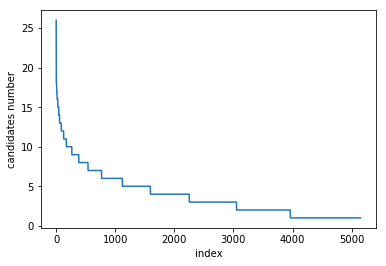

In [26]:
PROCESSCNT = 8
TOKEN = args.token
MULTIPROCESS = args.multi
PRE = args.pre
NB = args.nb

# TOKEN = 'd'
# MULTIPROCESS = True
# PRE = False
# NB = False

print('PRE\t{}NB\t{}'.format(PRE,NB))

# train_cnt_pars = list(range(1000, 5000, 1000))
# cost_pars = [0.125, 0.25, 0.5, 1, 2, 4, 8]
# gamma_pars = [0.0225, 0.045, 0.09, 0.18, 0.36]
# threshold = [0.9,50]
# ncm_setting_pars = [0.9995, 0.99995, 0.999995, 0.9999995]

train_cnt_pars = [4000]
cost_pars = [1]
gamma_pars = [0.09]
threshold = [0, 30]
ncm_setting_pars = [0.9995]


for train_cnt in train_cnt_pars:
    for cost in cost_pars:
        for gamma in gamma_pars:
            print('trainSet = {}\tcost_pars = {}\tgamma = {}'.format(train_cnt, cost, gamma))            
            batch_token = '{}_{}_{}_{}'.format(TOKEN, str(train_cnt), str(cost)[2:], str(gamma)[2:])
            (new_feature, pre_filter) = preprocess(feature, 'normal')
            label = rnSelect(new_feature, label)            
            clf, accuracy = train_svm(new_feature, label, train_cnt, cost, gamma)

            confu_raw = create(dataset)
            info(confu_raw, batch_token)
            for ncm_setting in ncm_setting_pars:
                confu = outputPKL(confu_raw, ncm_setting, output_file(TOKEN, batch_token, str(ncm_setting)[2:]))